# NEMA Photoelectric

- Photoelectric interaction in PETALO

In [1]:
import Pkg

In [2]:
Pkg.add.(["HTTP", "Plots", "DataFrames", "HDF5","DrWatson", "StatsBase", "PhysicalConstants"]);

In [3]:
Pkg.add.(["Test"]);

In [4]:
Pkg.add.(["VegaLite","VegaDatasets"]);

In [5]:
Pkg.add.(["LsqFit","GLM"])

2-element Vector{Nothing}:
 nothing
 nothing

In [861]:
Pkg.add("Distributions") 

In [1]:
using Distributions

In [2]:
using LsqFit
using GLM

In [3]:
using HTTP
using Plots
using VegaLite
using VegaDatasets
using DataFrames
using HDF5
using DrWatson
using Test
using PhysicalConstants
using PhysicalConstants.CODATA2018
using Unitful

In [4]:
using Glob
using CSV

In [5]:
using Statistics
using StatsBase
using Printf

In [6]:
using Logging

In [7]:
@quickactivate "JPetalo"

In [8]:
pwd()

"/Users/jj/JuliaProjects/JPetalo/notebooks"

In [9]:
datadir()

"/Users/jj/JuliaProjects/JPetalo/data"

In [10]:
srcdir()

"/Users/jj/JuliaProjects/JPetalo/src"

In [11]:
include(srcdir("jpetalo.jl"))

Main.JPetalo

In [12]:
import Unitful:
    nm, μm, mm, cm, m, km, inch, ft, mi,
    ac,
    mg, g, kg,
    Ra, °F, °C, K,
    rad, °,
    ns, μs, ms, ps, s, minute, hr, d, yr, Hz,
    eV,
    μJ, mJ, J,
	mW, μW, W,
    A, N, mol, mmol, V, L, mL, μL, M

In [13]:
function loglevel(log)
    if log == "Debug"
        logger = SimpleLogger(stdout, Logging.Debug)
    elseif log =="Info"
        logger = SimpleLogger(stdout, Logging.Info)
    else
        logger = SimpleLogger(stdout, Logging.Warn)
    end
    old_logger = global_logger(logger)
end

loglevel (generic function with 1 method)

# Characterization of PETALO

In [14]:
loglevel("Info")

Base.CoreLogging.SimpleLogger(IJulia.IJuliaStdio{Base.PipeEndpoint}(IOContext(Base.PipeEndpoint(RawFD(44) open, 0 bytes waiting))), Info, Dict{Any, Int64}())

### Read a summary data frame with photoelectric interactions

In [15]:
drx = datadir("nema3df")
input = string(drx,"/nemadf_f100_detconf_pde_03_sigmatof_85ps_kmeans_all.csv")
n3df = DataFrame(CSV.File(input));

In [16]:
println(names(n3df))

["nsipm1", "nsipm2", "q1", "q2", "r1", "r1q", "r2", "r2q", "t1", "t2", "ta1", "ta2", "tr1", "tr2", "ux", "uy", "uz", "x1", "x2", "xb1", "xb2", "xr1", "xr2", "xs", "xt1", "xt2", "y1", "y2", "yb1", "yb2", "yr1", "yr2", "ys", "yt1", "yt2", "z1", "z2", "zb1", "zb2", "zr1", "zr2", "zs", "zt1", "zt2"]


## Dependence of energy with radius of interaction
- Histograming the energy deposited in the SiPMs yields a wide and non gaussian distribution
- The reason is that the energy deposited in the SiPMs depends of the radius at which the gamms interacted.
- The relation is roughly linear in a good range of radius, cannot be used for charge too low and saturates for charge too high
- This dependence can be used to define an estimator, "rq" of the radius of interaction

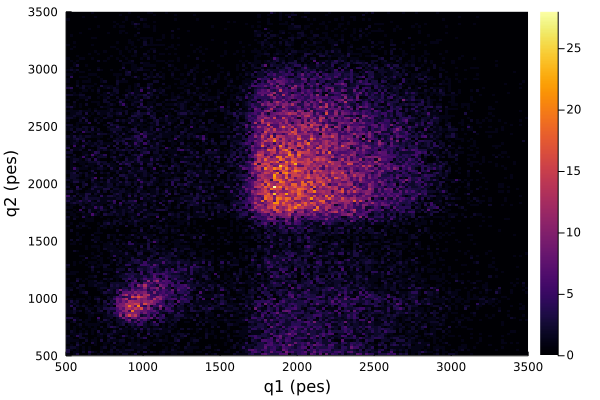

In [17]:
xe,ye,hqr,phqr = JPetalo.hist2d(n3df.q1,n3df.q2, 150, "q1 (pes)", "q2 (pes)", 0., 10000., 0., 10000.)
plot(phqr, legend=false, fmt = :png)

In [18]:
n3q1 = JPetalo.select_by_column_value_gt(n3df, "q1", 1800.0)
n3q  = JPetalo.select_by_column_value_gt(n3q1, "q2", 1800.0);

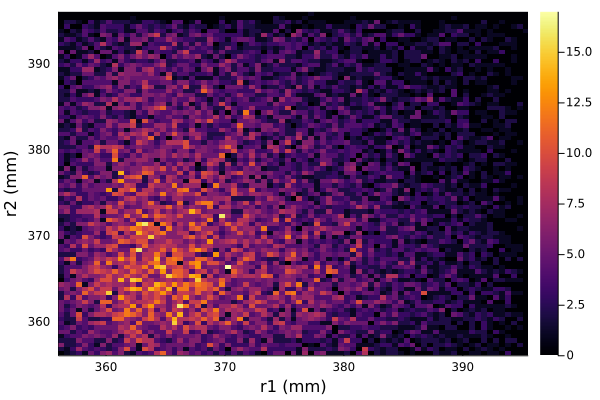

In [19]:
xe,ye,hqr,phqr = JPetalo.hist2d(n3q.r1,n3q.r2, 150, "r1 (mm)", "r2 (mm)", 350., 400., 350., 400.)
plot(phqr, legend=false, fmt = :png)

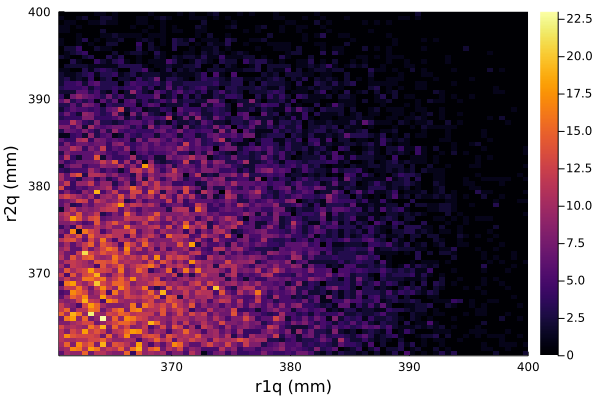

In [22]:
xe,ye,hqr,phqr = JPetalo.hist2d(n3q.r1q,n3q.r2q, 150, "r1q (mm)", "r2q (mm)", 300., 400., 300., 400.)
plot(phqr, legend=false, fmt = :png)

### R resolution

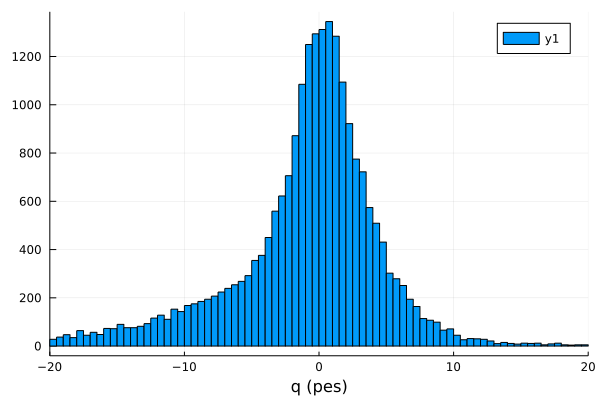

In [24]:
hqc = JPetalo.hist1d(n3q.r1 - n3q.r1q, 100, -20., 20.)
phqc = plot(hqc, xlim=(-20., 20.), xlabel="q (pes)")

In [26]:
g1p = (xmin= -20.0, xmax= -5.0, nbin=50)
g2p = (xmin= -5.0, xmax=  5.0, nbin=50)
gp  = (xmin= -20.0, xmax=  20.0, nbin=100)
fg = JPetalo.fit_2gauss_cmean(n3q.r1 - n3q.r1q, gp, g1p, g2p, 0.0)
@info "sigma" fg.sigma1 fg.sigma2

┌ Info: sigma
│   fg.sigma1 = 6.500962262502246
│   fg.sigma2 = 2.048446397201533
└ @ Main In[26]:5


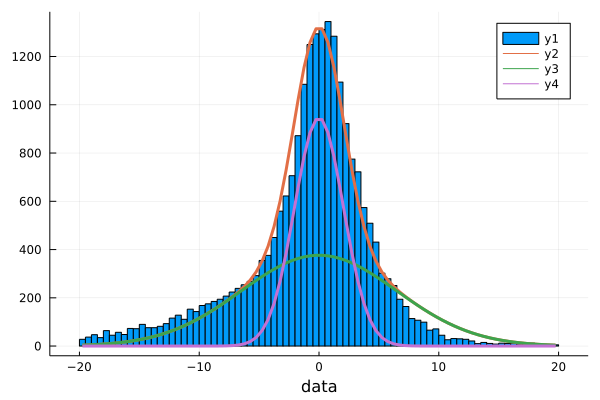

In [27]:
p = plot(fg.h, xlabel="data")
p = plot!(p,fg.xg, fg.yg, lw=3)
p = plot!(p,fg.xg, fg.gx1.(fg.xg), lw=3)
p = plot!(p,fg.xg, fg.gx2.(fg.xg), lw=3)

### Q vs R

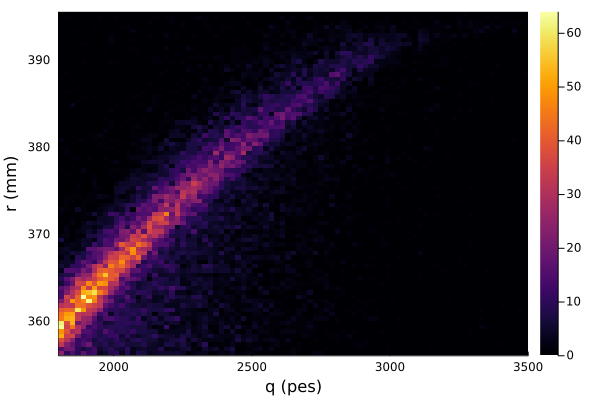

In [28]:
xe,ye,hqr,phqr = JPetalo.hist2d(n3q.q1,n3q.r1, 150, "q (pes)", "r (mm)")
plot(phqr, legend=false, fmt = :png)

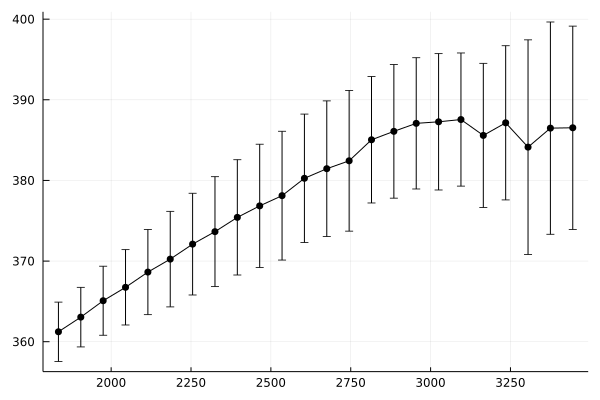

In [29]:
pqrdf = JPetalo.p1df(n3q.q1, n3q.r1, 25)
pp = plot(pqrdf.x_mean,pqrdf.y_mean, yerror=pqrdf.y_std, shape = :circle, color = :black, legend=false)

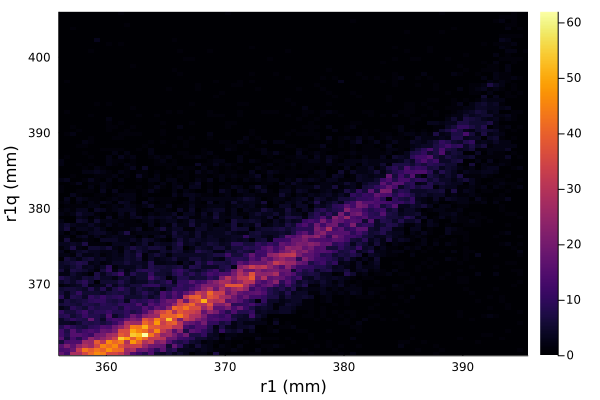

In [31]:
xe,ye,hqr,phqr = JPetalo.hist2d(n3q.r1,n3q.r1q, 150, "r1 (mm)", "r1q (mm)")
plot(phqr, legend=false, fmt = :png)

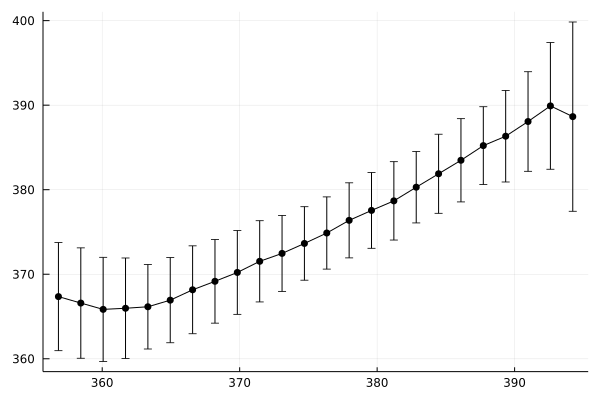

In [32]:
pqrdf = JPetalo.p1df(n3q.r1, n3q.r1q, 25)
pp = plot(pqrdf.x_mean,pqrdf.y_mean, yerror=pqrdf.y_std, shape = :circle, color = :black, legend=false)

### Number of SiPMs with charge above threshold

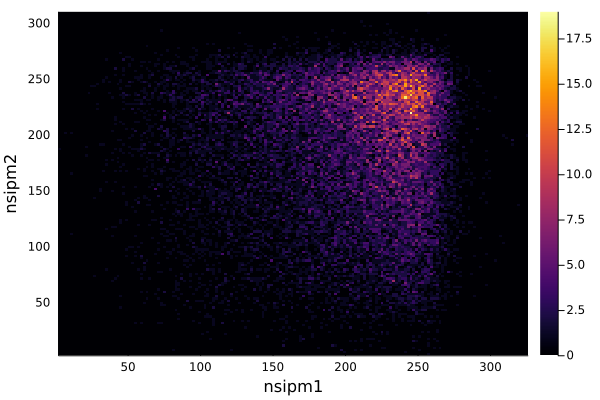

In [36]:
xe,ye,hqr,phqr = JPetalo.hist2d(n3q.nsipm1*1.,n3q.nsipm2*1., 150, "nsipm1", "nsipm2")
plot(phqr, legend=false, fmt = :png)

## Resolution in (x,y,z,r) intrinsic

In [37]:
limxy = 15.0;

In [91]:
hxtxr, pxtxr = JPetalo.hist1d(n3q.xt1 - n3q.x1, "xt - xr", 50,  -limxy, limxy);
plot(pxtxr,  layout = (1, 1), size = (500, 500), 
     legend=false, fmt = :png);

In [92]:
hytyr, pytyr = JPetalo.hist1d(n3q.yt1 - n3q.y1, "yt - yr", 50,  -limxy, limxy);
plot(pytyr,  layout = (1, 1), size = (500, 500), 
     legend=false, fmt = :png);

In [93]:
hztzr, pztzr = JPetalo.hist1d(n3q.zt1 - n3q.z1, "zt - zr", 50,  -limxy, limxy);
plot(pztzr,  layout = (1, 1), size = (500, 500), 
     legend=false, fmt = :png);

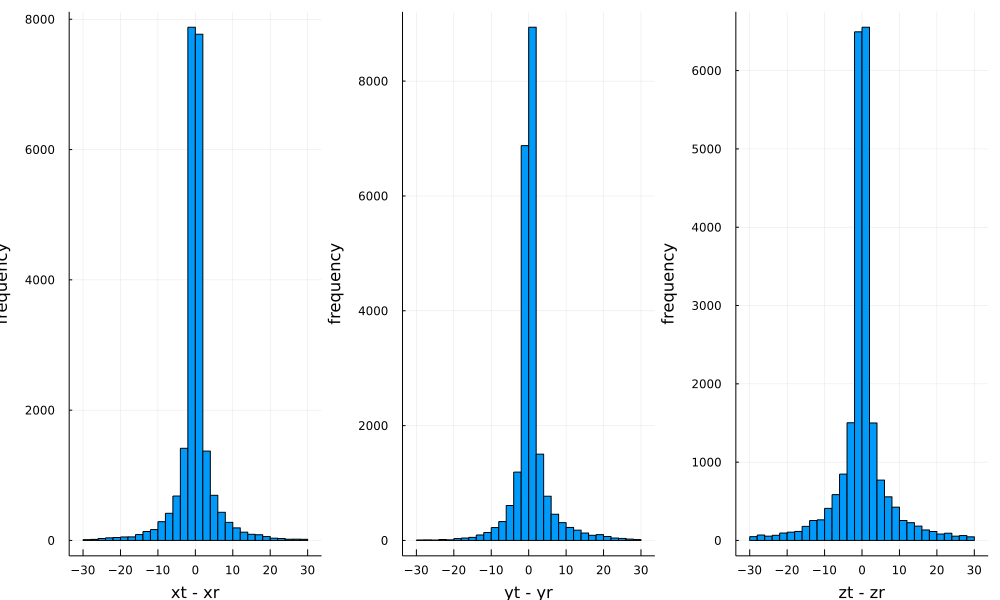

In [94]:
plot(pxtxr, pytyr,pztzr, layout = (1, 3), size = (1000, 600), 
     legend=false, fmt = :png)

In [97]:
g1p = (xmin= -15.0, xmax= -3.0, nbin=100)
g2p = (xmin= -3.0, xmax=  3.0, nbin=100)
gp  = (xmin= -15.0, xmax=  15.0, nbin=200)
fg = JPetalo.fit_2gauss_cmean(n3q.xt1 - n3q.x1, gp, g1p, g2p, 0.0)
@info "sigma" fg.sigma1 fg.sigma2

┌ Info: sigma
│   fg.sigma1 = 5.419613953644872
│   fg.sigma2 = 1.0005405654975437
└ @ Main In[97]:5


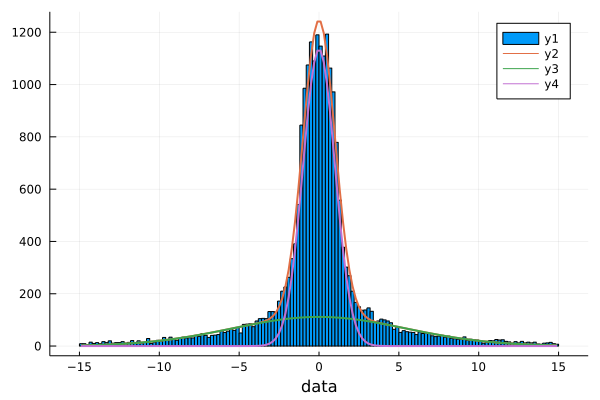

In [99]:
p = plot(fg.h, xlabel="data")
p = plot!(p,fg.xg, fg.yg, lw=2)
p = plot!(p,fg.xg, fg.gx1.(fg.xg), lw=2)
p = plot!(p,fg.xg, fg.gx2.(fg.xg), lw=2)

In [100]:
@info "resolution (mm): sigma = $(fg.sigma2)  FWHM = $(2.3 *fg.sigma2) "

┌ Info: resolution (mm): sigma = 1.0005405654975437  FWHM = 2.3012433006443502 
└ @ Main In[100]:1


## Resolution in xyz (r from q)

In [52]:
limxy = 30.0;

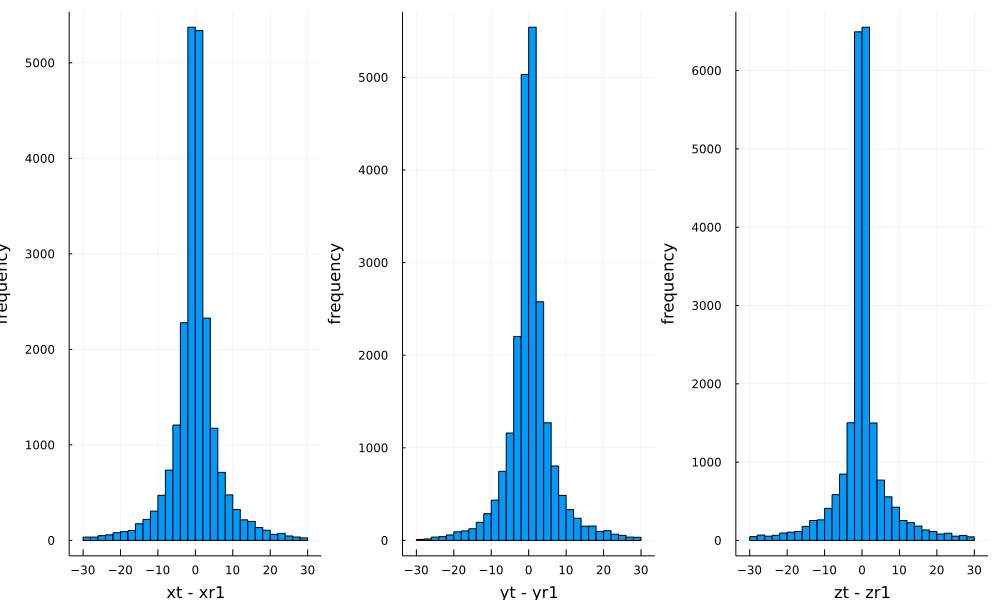

In [101]:
hxtxr, pxtxr = JPetalo.hist1d(n3q.xt1 - n3q.xr1, "xt - xr1", 50,  -limxy, limxy);
plot(pxtxr,  layout = (1, 1), size = (500, 500), 
     legend=false, fmt = :png);
hytyr, pytyr = JPetalo.hist1d(n3q.yt1 - n3q.yr1, "yt - yr1", 50,  -limxy, limxy);
plot(pytyr,  layout = (1, 1), size = (500, 500), 
     legend=false, fmt = :png);
hztzr, pztzr = JPetalo.hist1d(n3q.zt1 - n3q.zr1, "zt - zr1", 50,  -limxy, limxy);
plot(pztzr,  layout = (1, 1), size = (500, 500), 
     legend=false, fmt = :png);
plot(pxtxr, pytyr,pztzr, layout = (1, 3), size = (1000, 600), 
     legend=false, fmt = :png)

In [115]:
g1p = (xmin= -30.0, xmax= -5.0, nbin=100)
g2p = (xmin= -5.0, xmax=  5.0, nbin=100)
gp  = (xmin= -30.0, xmax=  30.0, nbin=200)
fg = JPetalo.fit_2gauss_cmean(n3q.y1 - n3q.yr1, gp, g1p, g2p, 0.0)
@info "sigma" fg.sigma1 fg.sigma2

┌ Info: sigma
│   fg.sigma1 = 2.9285285760211686
│   fg.sigma2 = 0.5770609882756904
└ @ Main In[115]:5


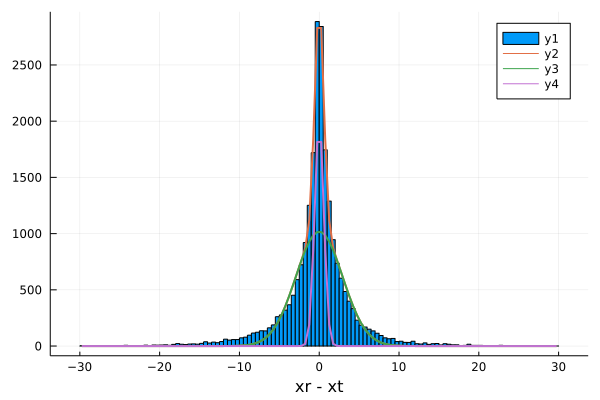

In [117]:
p = plot(fg.h, xlabel="xr - xt")
p = plot!(p,fg.xg, fg.yg, lw=2)
p = plot!(p,fg.xg, fg.gx1.(fg.xg), lw=2)
p = plot!(p,fg.xg, fg.gx2.(fg.xg), lw=2)

In [118]:
@info "resolution (mm): sigma = $(fg.sigma2)  FWHM = $(2.3 *fg.sigma2) "

┌ Info: resolution (mm): sigma = 0.5770609882756904  FWHM = 1.3272402730340878 
└ @ Main In[118]:1


## TOF

In [63]:
c0 =uconvert(mm/ns, float(SpeedOfLightInVacuum))

299.792458 mm ns⁻¹

In [64]:
cc = convert(Float32, c0/(mm*ns^-1))

299.79245f0

In [65]:
function ct12(df, t="nominal")
    if t == "minimum"
        return 1000.0*(df.tr1 - df.tr2)
    elseif t == "average"
        return 1000.0*(df.ta1 - df.ta2)
    else
        return 1000.0 * (df.t1 - df.t2)
    end
end
        


ct12 (generic function with 2 methods)

In [66]:
function ctsr(df, reco=true)
    if reco
        tsr1 = [JPetalo.dxyz([df.xr1[i], df.yr1[i], df.zr1[i]], 
                             [df.xs[i], df.ys[i], df.zs[i]]) for i in 1:nrow(df)]/cc
        tsr2 = [JPetalo.dxyz([df.xr2[i], df.yr2[i], df.zr2[i]], 
                             [df.xs[i], df.ys[i], df.zs[i]]) for i in 1:nrow(df)]/cc
        
    else
        tsr1 = [JPetalo.dxyz([df.x1[i], df.y1[i], df.z1[i]], 
                             [df.xs[i], df.ys[i], df.zs[i]]) for i in 1:nrow(df)]/cc
        tsr2 = [JPetalo.dxyz([df.x2[i], df.y2[i], df.z2[i]], 
                             [df.xs[i], df.ys[i], df.zs[i]]) for i in 1:nrow(df)]/cc
    end
    return 1000.0*(tsr1 - tsr2)
end

ctsr (generic function with 2 methods)

In [67]:
function crb(df, reco=true)
    clxe = cc/1.6
    if reco
        trb1 = [JPetalo.dxyz([df.xr1[i], df.yr1[i], df.zr1[i]], 
                             [df.xb1[i], df.yb1[i], df.zb1[i]]) for i in 1:nrow(df)]/clxe;
        trb2 = [JPetalo.dxyz([df.xr2[i], df.yr2[i], df.zr2[i]], 
                             [df.xb2[i], df.yb2[i], df.zb2[i]]) for i in 1:nrow(df)]/clxe;
        
    else
        trb1 = [JPetalo.dxyz([df.x1[i], df.y1[i], df.z1[i]], 
                             [df.xb1[i], df.yb1[i], df.zb1[i]]) for i in 1:nrow(df)]/clxe;
        trb2 = [JPetalo.dxyz([df.x2[i], df.y2[i], df.z2[i]], 
                             [df.xb2[i], df.yb2[i], df.zb2[i]]) for i in 1:nrow(df)]/clxe;
     end
    return 1000.0*(trb1 - trb2)
end

crb (generic function with 2 methods)

In [119]:
t12 = ct12(n3q, "nominal");

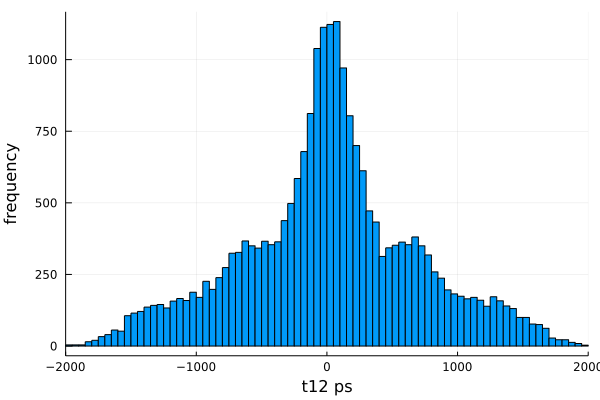

In [122]:
ht1t2, pt1t2 = JPetalo.hist1d(t12, "t12 ps", 100,  -2000., 2000.)
plot(pt1t2, xlimit=(-2000.0,2000.0), legend=false)

In [123]:
g1p = (xmin= -2000.0, xmax= -200.0, nbin=50)
g2p = (xmin= -200.0, xmax=  200.0, nbin=50)
gp  = (xmin= -2000.0, xmax=  2000.0, nbin=100)
fg = JPetalo.fit_2gauss_cmean(t12, gp, g1p, g2p, 0.0)
@info "sigma" fg.sigma1 fg.sigma2

┌ Info: sigma
│   fg.sigma1 = 826.3681420128821
│   fg.sigma2 = 144.06135249939143
└ @ Main In[123]:5


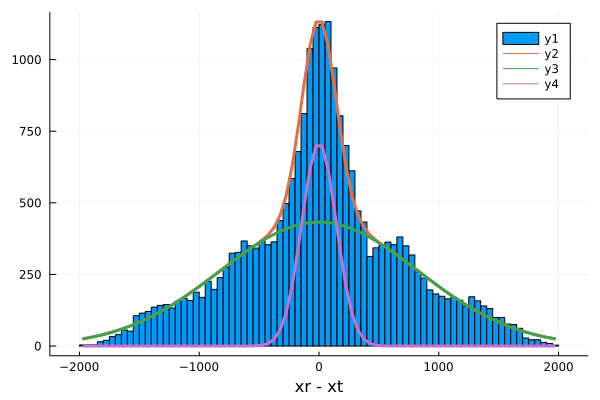

In [124]:
p = plot(fg.h, xlabel="xr - xt")
p = plot!(p,fg.xg, fg.yg, lw=3)
p = plot!(p,fg.xg, fg.gx1.(fg.xg), lw=3)
p = plot!(p,fg.xg, fg.gx2.(fg.xg), lw=3)

In [125]:
tsr12 = ctsr(n3q, false);

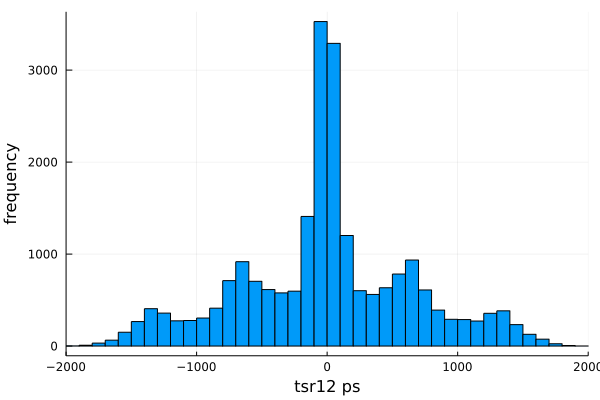

In [126]:
htsr12, psr1t2 = JPetalo.hist1d(tsr12, "tsr12 ps", 50,  -2000., 2000.)
plot(psr1t2, xlimit=(-2000.0,2000.0),legend=false) 

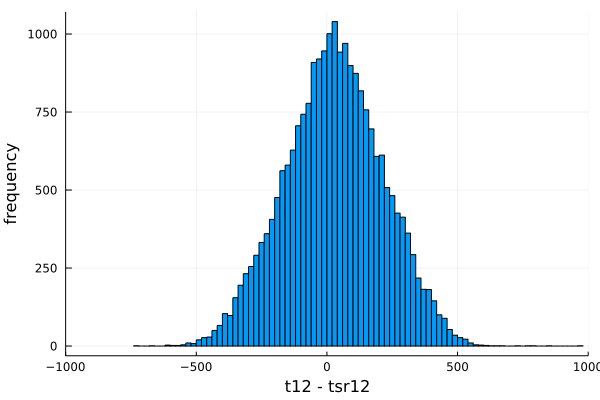

In [127]:
h12, p12 = JPetalo.hist1d(t12-tsr12, "t12 - tsr12", 100,  -1000., 1000.)
plot(p12, xlimit=(-1000.0,1000.0),legend=false) 

In [128]:
trb12 = crb(n3q, false);

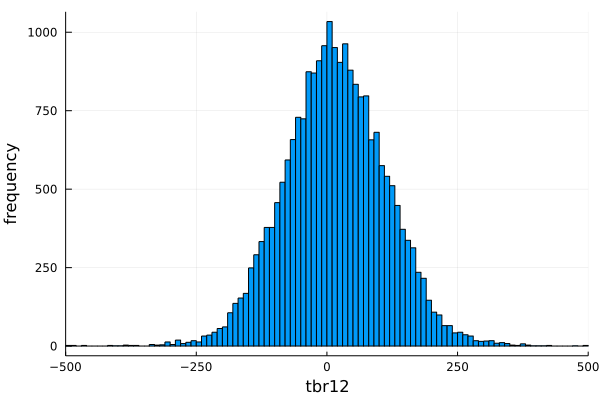

In [129]:
htrb12, ptrb12 = JPetalo.hist1d(trb12, "tbr12", 100,  -500., 500.)
plot(ptrb12, xlimit=(-500.0,500.0), legend=false) 

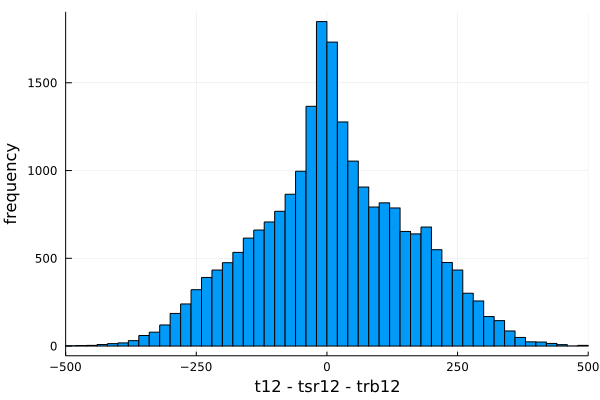

In [130]:
h12, p12 = JPetalo.hist1d(t12 - tsr12 - trb12  , "t12 - tsr12 - trb12", 75,  -500., 500.)
p12 = plot(p12, xlimit=(-500.0,500.0), legend=false) 

In [131]:
dt = t12 - tsr12 - trb12;

In [132]:
g1p = (xmin= -500.0, xmax= -50.0, nbin=50)
g2p = (xmin= -50.0, xmax=  50.0, nbin=50)
gp  = (xmin= -500.0, xmax=  500.0, nbin=100)
fg = JPetalo.fit_2gauss_cmean(dt, gp, g1p, g2p, 0.0)
@info "sigma" fg.sigma1 fg.sigma2

┌ Info: sigma
│   fg.sigma1 = 168.90651500647215
│   fg.sigma2 = 22.159678397892705
└ @ Main In[132]:5


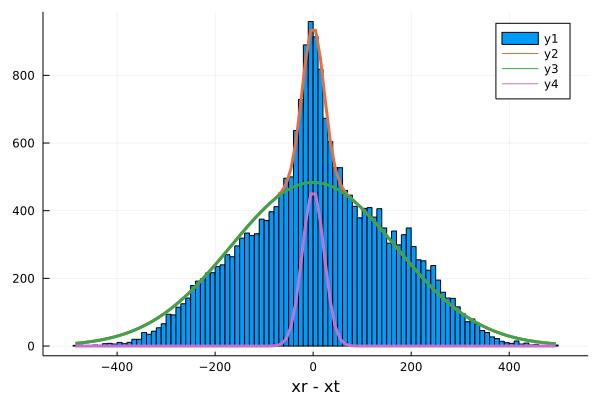

In [133]:
p = plot(fg.h, xlabel="xr - xt")
p = plot!(p,fg.xg, fg.yg, lw=3)
p = plot!(p,fg.xg, fg.gx1.(fg.xg), lw=3)
p = plot!(p,fg.xg, fg.gx2.(fg.xg), lw=3)

In [134]:
@info "FWHM: crt1 = $(2.3 * fg.sigma1) crt2 = $(2.3*fg.sigma2)" 

┌ Info: FWHM: crt1 = 388.4849845148859 crt2 = 50.96726031515322
└ @ Main In[134]:1


In [137]:
function crt(df, t="nominal", reco1=false, reco2=false)
    t12 = ct12(df, t)
    g1p = (xmin= -2000.0, xmax= -200.0, nbin=50)
    g2p = (xmin= -200.0, xmax=  200.0, nbin=50)
    gp  = (xmin= -2000.0, xmax=  2000.0, nbin=100)
    ft12 = JPetalo.fit_2gauss_cmean(t12, gp, g1p, g2p, 0.0)
    @info "t12: sigma" ft12.sigma1 ft12.sigma2

    tsr12 = ctsr(df, reco1)
    trb12 = crb(df, reco2)
    dt = t12 - tsr12 - trb12
    
    g1p = (xmin= -500.0, xmax= -50.0, nbin=50)
    g2p = (xmin= -50.0, xmax=  50.0, nbin=50)
    gp  = (xmin= -500.0, xmax=  500.0, nbin=100)
    fdt = JPetalo.fit_2gauss_cmean(dt, gp, g1p, g2p, 0.0)
    @info "dt: sigma" fdt.sigma1 fdt.sigma2
    return t12, dt, ft12, fdt

end

crt (generic function with 5 methods)

In [139]:
function plotg2fit(fg, label, lw=2)
    p = plot(fg.h, xlabel=label)
    p = plot!(p,fg.xg, fg.yg, lw=lw)
    p = plot!(p,fg.xg, fg.gx1.(fg.xg), lw=lw)
    p = plot!(p,fg.xg, fg.gx2.(fg.xg), lw=lw)
    return p
end

plotg2fit (generic function with 2 methods)

In [ ]:
pdt12 = plotg2fit(ft12, "dt12 nominal")

In [138]:
dt12, dt, ft12, fdt  = crt(n3q, "nominal", false, false);

┌ Info: t12: sigma
│   ft12.sigma1 = 826.3681420128821
│   ft12.sigma2 = 144.06135249939143
└ @ Main In[137]:7
┌ Info: dt: sigma
│   fdt.sigma1 = 168.90651500647215
│   fdt.sigma2 = 22.159678397892705
└ @ Main In[137]:17


In [144]:
pdt12 = plotg2fit(ft12, "dt12 nominal");

In [145]:
pdt = plotg2fit(fdt, "dt nominal");

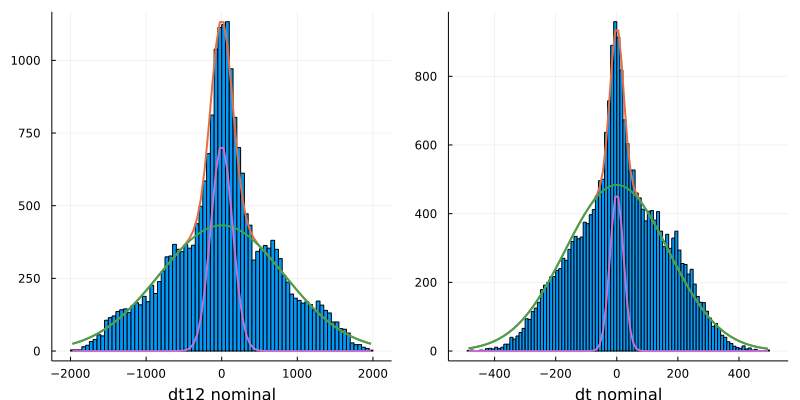

In [143]:
plot(pdt12, pdt, layout = (1, 2), size = (800, 400), 
     legend=false, fmt = :png) 

In [146]:
@info "FWHM: crt1 = $(2.3 * fdt.sigma1) crt2 = $(2.3*fdt.sigma2)" 

┌ Info: FWHM: crt1 = 388.4849845148859 crt2 = 50.96726031515322
└ @ Main In[146]:1


In [147]:
dt12, dt, ft12, fdt  = crt(n3q, "minimum", false, false);

┌ Info: t12: sigma
│   ft12.sigma1 = 825.0318519388495
│   ft12.sigma2 = 170.35357906503478
└ @ Main In[137]:7
┌ Info: dt: sigma
│   fdt.sigma1 = 54.947071102297656
│   fdt.sigma2 = 175.6081895071956
└ @ Main In[137]:17


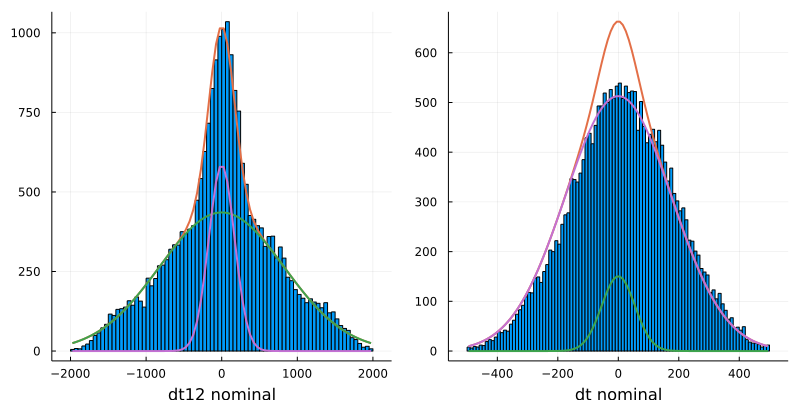

In [148]:
pdt12 = plotg2fit(ft12, "dt12 nominal");
pdt = plotg2fit(fdt, "dt nominal");
plot(pdt12, pdt, layout = (1, 2), size = (800, 400), 
     legend=false, fmt = :png) 

In [149]:
@info "FWHM: crt1 = $(2.3 * fdt.sigma1) crt2 = $(2.3*fdt.sigma2)" 

┌ Info: FWHM: crt1 = 126.3782635352846 crt2 = 403.8988358665498
└ @ Main In[149]:1


In [150]:
dt12, dt, ft12, fdt  = crt(n3q, "average", false, false);

┌ Info: t12: sigma
│   ft12.sigma1 = 832.358537968361
│   ft12.sigma2 = 163.8504827014415
└ @ Main In[137]:7
┌ Info: dt: sigma
│   fdt.sigma1 = 156.71991220500576
│   fdt.sigma2 = 156.7227145264434
└ @ Main In[137]:17


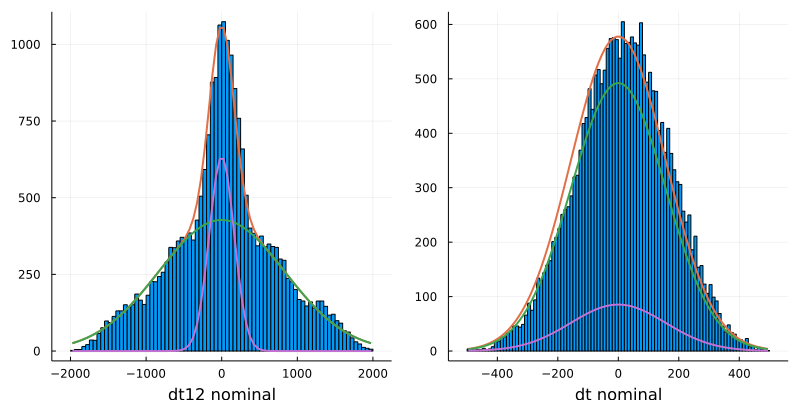

In [151]:
pdt12 = plotg2fit(ft12, "dt12 nominal");
pdt = plotg2fit(fdt, "dt nominal");
plot(pdt12, pdt, layout = (1, 2), size = (800, 400), 
     legend=false, fmt = :png) 

In [152]:
@info "FWHM: crt1 = $(2.3 * fdt.sigma1) crt2 = $(2.3*fdt.sigma2)" 

┌ Info: FWHM: crt1 = 360.4557980715132 crt2 = 360.46224341081984
└ @ Main In[152]:1


In [154]:
dt12, dt, ft12, fdt  = crt(n3q, "average", true, true);

┌ Info: t12: sigma
│   ft12.sigma1 = 832.358537968361
│   ft12.sigma2 = 163.8504827014415
└ @ Main In[137]:7
┌ Info: dt: sigma
│   fdt.sigma1 = 156.29748329882736
│   fdt.sigma2 = 156.29894445138947
└ @ Main In[137]:17
